In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3060
Using device: cuda


In [5]:
source='Input\pruebadefuego'
test=[os.path.join(source, i) for i in os.listdir(source)]

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\gonza\AppData\Local\Temp\ipykernel_17880\3836359004.py:1: SyntaxWarning: invalid escape sequence '\p'
  source='Input\pruebadefuego'


prepro

In [8]:
def process_image(file_name):
    np_sat = np.array(Image.open(file_name).resize((256, 256)))[..., :3]
    return np_sat
results = []

for i in tqdm(test):
    results.append(process_image(i))

x_val=np.array(results)

100%|██████████| 11/11 [00:02<00:00,  3.72it/s]


In [15]:
x_val.shape

(11, 256, 256, 3)

Modelos

In [11]:
# Bloque de atención
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


# Bloque de convolución doble
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


# Modelo Attention U-Net
class AttentionUNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(AttentionUNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(input_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)

        # Salida
        self.out = nn.Conv2d(64, output_channels, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        up4 = self.up4(bottleneck)
        att4 = self.att4(up4, enc4)
        dec4 = self.dec4(torch.cat([up4, att4], dim=1))

        up3 = self.up3(dec4)
        att3 = self.att3(up3, enc3)
        dec3 = self.dec3(torch.cat([up3, att3], dim=1))

        up2 = self.up2(dec3)
        att2 = self.att2(up2, enc2)
        dec2 = self.dec2(torch.cat([up2, att2], dim=1))

        up1 = self.up1(dec2)
        att1 = self.att1(up1, enc1)
        dec1 = self.dec1(torch.cat([up1, att1], dim=1))

        out = self.out(dec1)

        return out


In [ ]:
X_test_tensor = torch.tensor(x_val, dtype=torch.float32).permute(0, 3, 1, 2)  # 
test_loader = DataLoader(X_test_tensor, batch_size=8, shuffle=False, pin_memory= True)

In [13]:
model3 = torch.load(r"Modelos\3\complete_2_model.pth")
model3 = model3.to(device)
model4 = torch.load(r"Modelos\4\model_ultimo_model.pth")
model4 = model4.to(device)

C:\Users\gonza\AppData\Local\Temp\ipykernel_17880\172026803.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3 = torch.load(r"Modelos\3\complete_2_model.pth")
C:\Use

In [ ]:
predicted_masks_model3=[]
predicted_masks_model4=[]
with torch.no_grad():  
    for images in tqdm(test_loader, desc="Evaluación"):
        images = images.to(device)
        outputs3 = model3(images)
        predictions3 = torch.argmax(outputs3, dim=1)  
        predicted_masks_model3.append(predictions3.cpu().numpy())        
        
        outputs4 = model4(images)
        predictions4 = torch.argmax(outputs4, dim=1)  
        predicted_masks_model4.append(predictions4.cpu().numpy())

Evaluación: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


In [24]:
color_map = {
        0: [0, 0, 0],     
        1: [255, 255, 255],    
    }
def pre_rgb(image):
    rgb_img=np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for class_value, color in color_map.items():
        rgb_img[image == class_value] = color
    return rgb_img

In [35]:
l=[]
for i in predicted_masks_model4:
    l.extend(i)
predicted_masks_model4=np.array(l)
l=[]
for i in predicted_masks_model3:
    l.extend(i)
predicted_masks_model3=np.array(l)

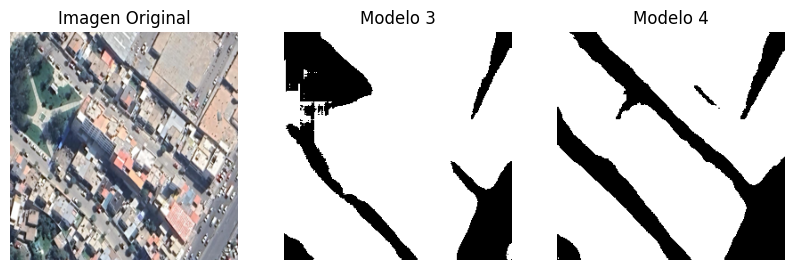

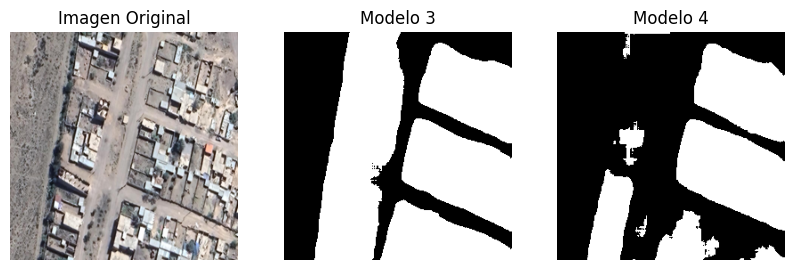

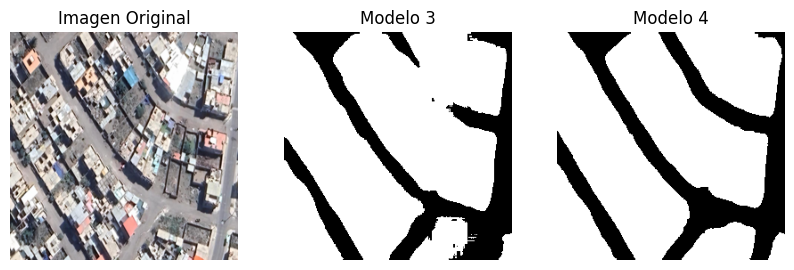

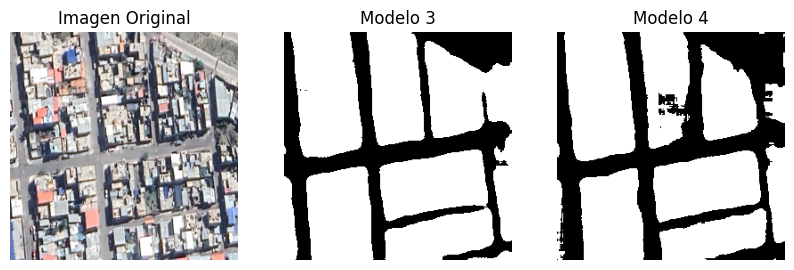

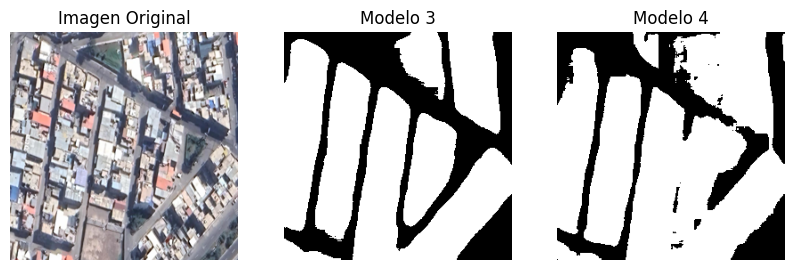

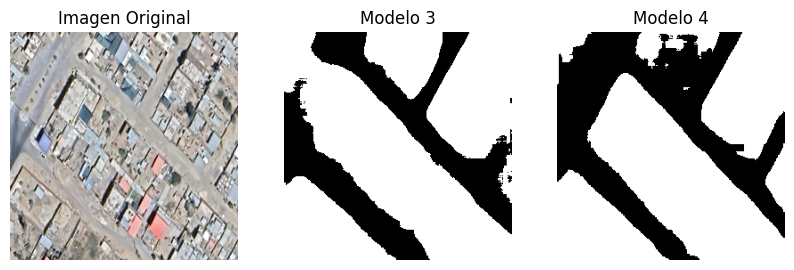

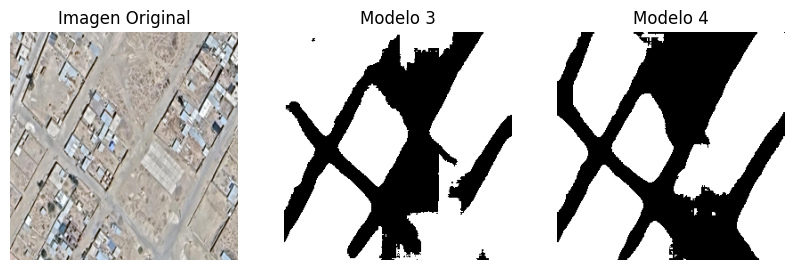

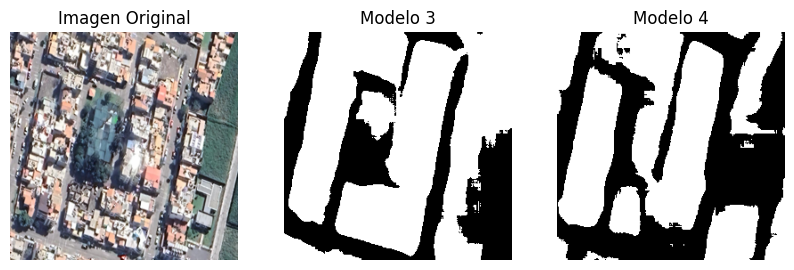

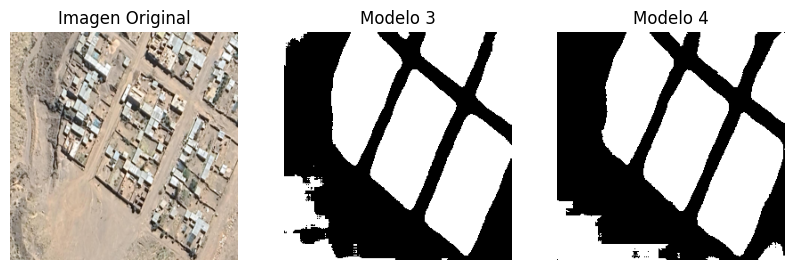

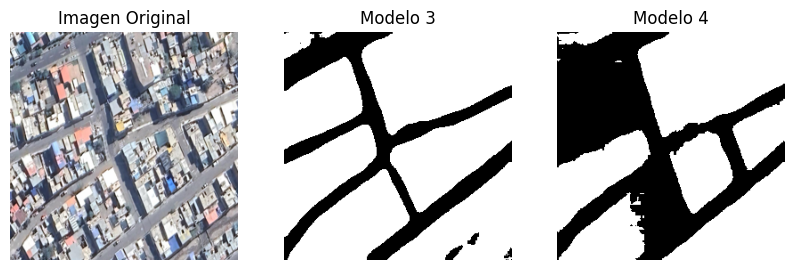

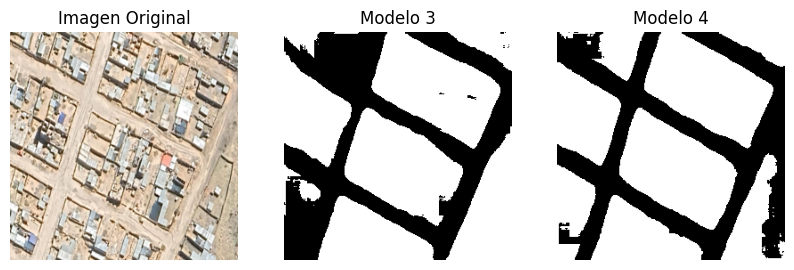

In [ ]:
def test_graph(i):
    plt.figure(figsize=(10, 5))
    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(x_val[i])
    plt.axis("off")
    plt.title("Imagen Original")

    # Máscara Real
    plt.subplot(1, 3, 2)
    model3_pre = pre_rgb(predicted_masks_model3[i])  
    plt.imshow(model3_pre)
    plt.axis("off")
    plt.title("Modelo 3")

    # Máscara Predicha
    plt.subplot(1, 3, 3)
    model4_pre = pre_rgb(predicted_masks_model4[i]) 
    plt.imshow(model4_pre)
    plt.axis("off")
    plt.title("Modelo 4")

for i in range(len(x_val)):
    test_graph(i)

In [47]:
np.save('miguel_test.npy',predicted_masks_model4)